In [1]:
!git clone https://github.com/sayakpaul/Sharpness-Aware-Minimization-TensorFlow

import sys
import matplotlib.pyplot as plt 
import tensorflow as tf 

Cloning into 'Sharpness-Aware-Minimization-TensorFlow'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 73 (delta 32), reused 23 (delta 4), pack-reused 0 (from 0)
Unpacking objects: 100% (73/73), 157.38 KiB | 3.75 MiB/s, done.


2024-08-17 09:36:58.849634: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 09:36:58.849768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 09:36:58.977186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepare Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"Training samples: {len(x_train)}")
print(f"Testing samples: {len(x_test)}")

batch_size = 128

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training samples: 50000
Testing samples: 10000


In [3]:
# Chuyen doi du lieu hinh anh
def scale(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label


# Tang cuong du lieu
def augment(image, label):
    image = tf.image.random_crop(image, size = [32, 32, 3])        # Cắt ngẫu nhiên trở lại 32x32
    image = tf.image.random_brightness(image, max_delta = 0.5)     # Độ sáng ngẫu nhiên
    image = tf.clip_by_value(image, 0., 1.)                        # Giới hạn pixel thuộc [0, 1]
    return image, label


# Thiet lap du lieu training
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.shuffle(1024).map(scale)
    .map(augment).batch(batch_size)
)


# Thiet lap du lieu test
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(scale).batch(batch_size)
)

# Initialize Model

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

In [5]:
class SAM(tf.keras.Model):
    def __init__(self, Resnet50, rho = 0.05):
        # Override
        super(SAM, self).__init__()
        self.Resnet50 = Resnet50
        self.rho = rho
        
    def call(self, inputs, training=False):
        return self.Resnet50(inputs, training=training)
    
    def train(self, data):
        (images, labels) = data
        with tf.GradientTape() as tape:
            predictions = self.Resnet50(images)
            loss = self.compiled_loss(labels, predictions)   # Sẽ thiết lập loss ở sau đó
        
        # Tinh e(w) voi p = 2
        e_w = []
        train_params = self.Resnet50.trainable_variables
        grad = tape.gradient(loss, train_params)
        grad_norm = self.grad_norm(grad_norm)                 # Độ lớn của gradient
        scale = self.rho / (grad_norm + 1e-12)
        
        for(grad, param) in zip(grad, train_params):
            g = grad * scale
            param.assign_add(g)
            e_w.append(g)
        
        with tf.GradientTape() as tape:
            predictions = self.Resnet50(images)
            loss = self.compiled(labels, predictions)
        
        sam_grad = tape.gradient(loss, train_params)
        
        # Khoi phuc lai tham so
        for (g, param) in zip(e_w, train_params):
            param.assind_sub(g)
        
        self.optimizer.apply_gradients(zip(sam_grad, train_params))
        
        # Cap nhat phan tu trong metrics
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}
    
    def test(self, data):
        (images, labels) = data
        predictions = self.Resnet50(images, training = False)
        loss = self.compiled_loss(labels, predictions)
        self.compiled_metrics.update_state(labels, predictions)
        return {m.name: m.result() for m in self.metrics}
    
    
    # Tinh do lon cua gradient cua tat ca grad khac 0
    def grad_norm(self, grad):
        norm = tf.norm(
            tf.stack([tf.norm(g) for g in grad if g is not None])
        )
        return norm
        
    

# Training Model with SAM

In [6]:
def get_training_model():
    # Sử dụng ResNet50, bỏ lớp cuối cùng và thêm lớp mới cho CIFAR-10
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    
    # Đóng băng các tầng của ResNet50
    base_model.trainable = False
    
    # Xây dựng mô hình với lớp phân loại cho CIFAR-10
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

In [7]:
model = SAM(get_training_model())
model.compile(
    optimizer = "sgd",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
import time 
start = time.time()
history = model.fit(train_dataset,
                    validation_data = test_dataset,
                   epochs = 200)
print("Total training time", time.time() - start, "s")

Epoch 1/200
 10/391 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0951 - loss: 5.0681

I0000 00:00:1723887454.988151      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1215 - loss: 2.5961

W0000 00:00:1723887463.706973      72 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 43ms/step - accuracy: 0.1216 - loss: 2.5955 - val_accuracy: 0.2056 - val_loss: 2.2172
Epoch 2/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.1628 - loss: 2.2350 - val_accuracy: 0.2152 - val_loss: 2.1546
Epoch 3/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1832 - loss: 2.1971 - val_accuracy: 0.2519 - val_loss: 2.0915
Epoch 4/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2008 - loss: 2.1724 - val_accuracy: 0.1936 - val_loss: 2.1949
Epoch 5/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2107 - loss: 2.1450 - val_accuracy: 0.2885 - val_loss: 2.0054
Epoch 6/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2141 - loss: 2.1371 - val_accuracy: 0.2118 - val_loss: 2.0784
Epoch 7/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.2247 - loss: 2.1113 - val_accuracy: 0.2713 - val_loss: 2.0245
Epoch 8/200
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2277 - loss: 2.1036 - val_accur

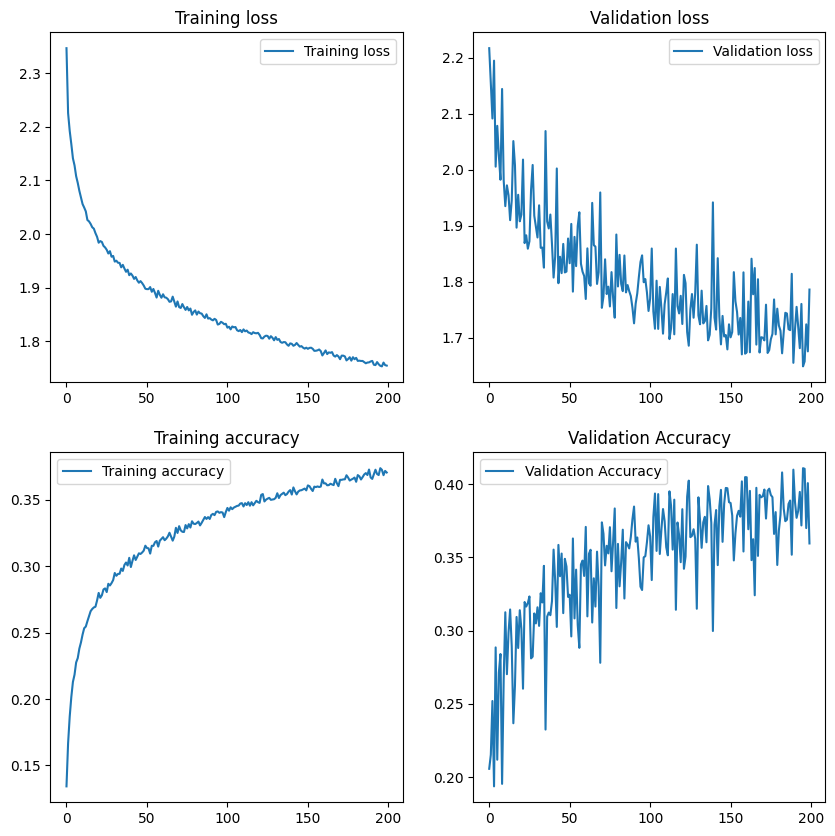

In [9]:
_, axes = plt.subplots(2, 2, figsize = (10, 10))
labels = ["Training loss", "Validation loss", "Training accuracy", "Validation Accuracy"]
est = ["loss", "val_loss", "accuracy", "val_accuracy"]

for i, ax in enumerate(axes.flat):
    ax.plot(history.history[est[i]], label = labels[i])
    ax.set_title(labels[i])
    ax.legend()
    
plt.show()